# Balancing Robot simulation

This notebook goes through the development of a controller for stabilizing a balancing robot. Starting from the equations of motion than making a model in MATLAB and finally simulating in the mujoco framework.

In [37]:
import mujoco
import mediapy as media
import numpy as np
import matplotlib.pyplot as plt

xml = """
<mujoco model="balancing robot">
    <option integrator="RK4" timestep="0.001"/>

    <visual>
        <global offheight="2160" offwidth="3840"/>
        <quality offsamples="8"/>
    </visual>

    <asset>
        <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
            rgb2=".2 .3 .4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>

        <texture name="wheel" type="2d" builtin="checker" rgb1=".1 .1 .1"
            rgb2=".5 .5 .5" width="300" height="300"/>
        <material name="wheel" texture="wheel" texrepeat="2 2" reflectance=".2"/>
    </asset>

    <worldbody>
        <geom size="1 1 .01" type="plane" material="grid"/>
        <light pos="0 0 1"/>
        <camera name="closeup" pos=".3 -.4 .25" xyaxes="1 .8 0 0 1 2"/>
        <body name="top" pos="0 0 0">
            <freejoint/>
            <site name="IMU"/>
            <geom name="body" type="box" size=".0275 .080 .075" pos="0 0 .095" mass=".46" rgba="1 0 0 1"/>
            <body name="right wheel" pos="0 0 .02">
                <joint name="right wheel" type="hinge" axis="0 1 0" pos="0 0 .02"/>
                <geom name="right wheel" type="cylinder" pos="0 -0.1 .02" size="0.04 .0175" mass=".04" zaxis="0 1 0" material="wheel"/>
            </body>
            <body name="left wheel" pos="0 0 .02">
                <joint name="left wheel" type="hinge" axis="0 1 0" pos="0 0 .02"/>
                <geom name="left wheel" type="cylinder" pos="0 0.1 .02" size="0.04 .0175" mass=".04" zaxis="0 1 0" material="wheel"/>
            </body>
        </body>
    </worldbody>

    <actuator>
        <motor name="motor right" joint="right wheel" gear="1"/>
        <motor name="motor left" joint="left wheel" gear="1"/>
    </actuator>

    <sensor>
        <accelerometer name="accelerometer" site="IMU"/>
        <framezaxis name="top z axis" objtype="body" objname="top"/>
        <frameyaxis name="top y axis" objtype="body" objname="top"/>
    </sensor>
    
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

## Render picture of the agent

""

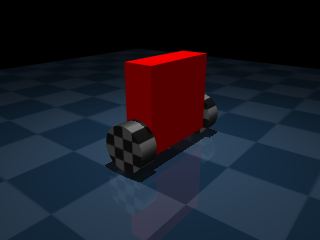

In [3]:
# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="closeup")
    media.show_image(renderer.render())

In [4]:
duration = 1  # (seconds)
framerate = 60  # (Hz)
height = 320
width = 480
slowdown = 6    # 4x slow-down

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 0.2

# Simulate and display video.
frames = []
with mujoco.Renderer(model, height, width) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate * slowdown:
            renderer.update_scene(data, camera="closeup")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

## Controlling the agent

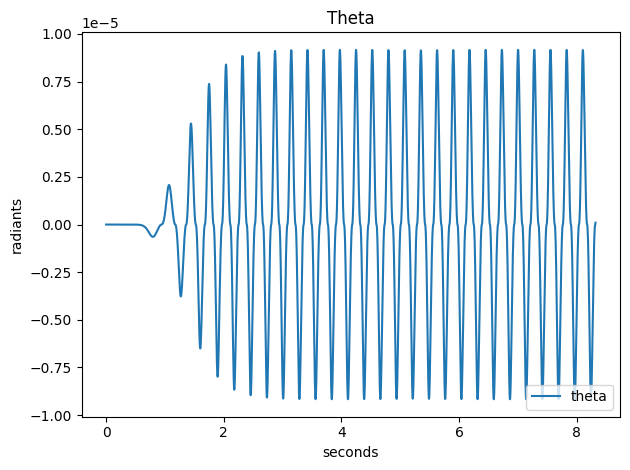

In [55]:
def get_angle(data):
	z_axis = data.sensor('top z axis').data.copy()
	y_axis = data.sensor('top y axis').data.copy()
	cross = np.cross(z_axis, [0, 0, 1])
	theta = np.arcsin(np.linalg.norm(cross)) * np.dot(cross, y_axis)
	return theta

class Controller:

	def __init__(self):
		self.b = [2.076, -4.03, 1.955]
		self.a = [1.86, -0.8605]
		self.x = [0] * len(self.b)
		self.y = [0] * len(self.a)
		

	def compute(self, imu, theta: float):

		# shift current value into the buffer
		self.x = [theta] + self.x[0:-1]

		# Compute value
		y = 100 * np.sum(np.multiply(self.b, self.x)) + np.sum(np.multiply(self.a, self.y))

		self.y = [y] + self.y[0:-1]

		# Compute motor torque
		turning = 0.01
		right_motor_torque = -y
		left_motor_torque = -y

		return [right_motor_torque + turning, left_motor_torque - turning]


def main():
	n_frames = 500
	height = 240
	width = 320
	frames = []
	fps = 60.0
	times = []
	sensordata = []
	theta = []

	controller = Controller()

	# constant actuator signal
	mujoco.mj_resetData(model, data)
	
	# Simulate and display video.
	with mujoco.Renderer(model, height, width) as renderer:
		for i in range(n_frames):
			while data.time < i/fps:
				mujoco.mj_step(model, data)
				times.append(data.time)
				theta.append(get_angle(data))
				acc_data = data.sensor('accelerometer').data.copy()
				command = controller.compute(acc_data, theta[-1])
				data.ctrl = command
				sensordata.append(acc_data)
			renderer.update_scene(data, camera="closeup")
			frame = renderer.render()
			frames.append(frame)

	media.show_video(frames, fps=fps)

	ax = plt.gca()
	ax.plot(np.asarray(times), np.asarray(theta), label="theta")
	ax.set_title('Theta')
	ax.set_ylabel('radiants')
	ax.set_xlabel('seconds')
	ax.legend(frameon=True, loc='lower right')
	plt.tight_layout()


if __name__=="__main__":
	main()